In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

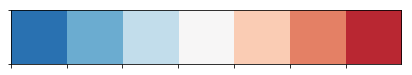

In [4]:
import seaborn as sns
sns.palplot(sns.color_palette("RdBu_r", 7))

sns.set_style("whitegrid")

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [5]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


<p>Base com todas chuvas EXTREMAS com inicio e fim de cada chuva extrema (> 50mm em 24 horas)</p>

In [6]:
dfhr = pd.read_csv('../data/extreme_prcp_evolution.csv')
print len(dfhr)

31710


<p>Subconjunto da base principal considerando o inicio e fim das chuvas extremas (> 50mm em 24 horas)</p>

In [7]:
dfext = pd.read_csv('../data/sudeste_extreme_prcp.csv', index_col=0)
print len(dfext)

101976


# Pré-processamento

<h3>Limpeza dos dados</h3>

In [8]:
# Campos não numericos e campos derivados
DES= ['wsid','wsnm','elvt','lat','lon','inme','city','prov']
INT = ['yr','mo','da','hr']
DAT = ['mdct','date']
DER = ['smax','smin','tmax','tmin','dmax','dmin','hmax','hmin']

In [25]:
# dataframe apenas com os dados continuos
dfcont = df
for f in DES + INT + DAT:    
    dfcont = dfcont.drop(f, 1)

In [26]:
dfcont = dfcont.apply(pd.to_numeric, errors='coerce')  

In [29]:
dfcont.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9779168 entries, 0 to 9779167
Data columns (total 17 columns):
prcp    float64
stp     float64
smax    float64
smin    float64
gbrd    float64
temp    float64
tmax    float64
tmin    float64
dewp    float64
dmax    float64
dmin    float64
hmdy    float64
hmax    float64
hmin    float64
wdsp    float64
wdct    float64
gust    float64
dtypes: float64(17)
memory usage: 1.2 GB


In [30]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,1407984.0,0.936654,2.923291,0.0,0.0,0.000,0.6,100.000
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.200,973.1,1050.000
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.400,973.3,1050.000
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.900,972.8,1050.000
gbrd,5670348.0,1176.371062,1138.753521,0.0,65.0,863.427,2103.0,11586.491
temp,9779137.0,20.474225,7.331125,-3.8,17.7,21.400,24.9,44.900
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.100,18.9,42.700
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.900,25.8,45.000
dewp,9778858.0,15.240249,5.866811,-10.0,12.7,16.600,19.4,44.800
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.800,24.2,45.000


<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [35]:
dfcont =  dfcont.drop('gbrd',1)
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [36]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [37]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)
    dfcont[v] = dfcont[v].fillna(0.0)  

<p>Vamos ver como os dados contínuos estão organizados: MÍNIMOS, MÁXIMOS, MEDIAS</p>

In [38]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779137.0,20.474225,7.331125,-3.8,17.7,21.4,24.9,44.9
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.1,18.9,42.7
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.9,25.8,45.0
dewp,9778858.0,15.240249,5.866811,-10.0,12.7,16.6,19.4,44.8
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.8,24.2,45.0
dmin,9778361.0,14.220885,5.777089,-10.0,11.6,15.6,18.4,44.9


<p>A temperatura será inputada pela média</p>

In [51]:
MEAN = ['temp','dewp']

In [52]:
for v in MEAN:
    df[v] = df[v].fillna(value=df[v].median())
    dfcont[v] = dfcont[v].fillna(value=dfcont[v].median())

In [53]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779168.0,20.474228,7.331113,-3.8,17.7,21.4,24.9,44.9
tmax,9778693.0,14.726810,5.805413,-10.0,12.1,16.1,18.9,42.7
tmin,9779142.0,21.105026,7.545549,-3.2,18.2,21.9,25.8,45.0
dewp,9779168.0,15.240292,5.866723,-10.0,12.7,16.6,19.4,44.8
dmax,9779134.0,19.864175,7.134849,-8.5,17.2,20.8,24.2,45.0
dmin,9778361.0,14.220885,5.777089,-10.0,11.6,15.6,18.4,44.9


In [54]:
for v in ['tmax','tmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['temp'])
    df[v] = df[v].fillna(value=df['temp'])
for v in ['dmax','dmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['dewp'])
    df[v] = df[v].fillna(value=df['dewp'])
for v in ['hmax','hmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['hmdy'])
    df[v] = df[v].fillna(value=df['hmdy'])

In [55]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,9779168.0,0.134858,1.156940,0.0,0.0,0.0,0.0,100.0
stp,9779168.0,880.429177,248.264986,0.0,911.3,944.2,973.1,1050.0
smax,9779168.0,880.303394,248.917148,0.0,911.5,944.4,973.3,1050.0
smin,9779168.0,879.833097,248.771557,0.0,911.0,943.9,972.8,1050.0
temp,9779168.0,20.474228,7.331113,-3.8,17.7,21.4,24.9,44.9
tmax,9779168.0,14.727113,5.805794,-10.0,12.1,16.1,18.9,42.7
tmin,9779168.0,21.104973,7.545616,-3.2,18.2,21.9,25.8,45.0
dewp,9779168.0,15.240292,5.866723,-10.0,12.7,16.6,19.4,44.8
dmax,9779168.0,19.864112,7.134923,-8.5,17.2,20.8,24.2,45.0
dmin,9779168.0,14.219949,5.777816,-10.0,11.6,15.6,18.4,44.9


<h3>Derivando novas variáveis</h3>

<p>O objetivo é derivar cada variável climática contínua em uma nova variável t-1, t-2, t-3... t-n, onde n é o numeros de horas antes do momento t. Vamos primeiramente derivá-las para depois verificar quais quando massivamente as variávies estão zeradas, o que pode indicar que a estação falhou.</p>

<p>Utilizando um exemplo especifico de uma estação, depois verificamos o conjunto maior</p> 

In [115]:
dfm = df[(df.wsid==329)]
len(dfm)

87456

In [116]:
dfm.index = pd.to_datetime(dfm.mdct)
dfm.head(4)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
mdct,,,,,,,,,,,,,,,,,,,,,
2006-10-10 00:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 00:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 01:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 01:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 02:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 02:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 03:00:00,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-10-10 03:00:00,2006-10-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
CLEAN = ['wsnm','inme','city','prov','mdct','date']
REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
for v in CLEAN + REMOVE:
    dfm = dfm.drop(v,1)
dfm.head(5)  

,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
mdct,,,,,,,,,,,,,,,,,,,
2006-10-10 00:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 01:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 02:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 03:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 04:00:00,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
def derive_nth_hour_feature(df, feature, N):  
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = np.nan
    df.loc[:][col_name] = nth_prior_measurements

In [119]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

for feature in dfm.columns:
    if feature not in NON_DER:
        for h in range(1,6):
            derive_nth_hour_feature(dfm, feature, h) 

In [120]:
REMOVE = [u'prcp_1', u'prcp_2', u'prcp_3', u'prcp_4', u'prcp_5']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [121]:
dfm.columns

Index([u'elvt', u'lat', u'lon', u'prcp', u'stp', u'smax', u'smin', u'temp',
       u'tmax', u'tmin', u'dewp', u'dmax', u'dmin', u'hmdy', u'hmax', u'hmin',
       u'wdsp', u'wdct', u'gust', u'stp_1', u'stp_2', u'stp_3', u'stp_4',
       u'stp_5', u'smax_1', u'smax_2', u'smax_3', u'smax_4', u'smax_5',
       u'smin_1', u'smin_2', u'smin_3', u'smin_4', u'smin_5', u'temp_1',
       u'temp_2', u'temp_3', u'temp_4', u'temp_5', u'tmax_1', u'tmax_2',
       u'tmax_3', u'tmax_4', u'tmax_5', u'tmin_1', u'tmin_2', u'tmin_3',
       u'tmin_4', u'tmin_5', u'dewp_1', u'dewp_2', u'dewp_3', u'dewp_4',
       u'dewp_5', u'dmax_1', u'dmax_2', u'dmax_3', u'dmax_4', u'dmax_5',
       u'dmin_1', u'dmin_2', u'dmin_3', u'dmin_4', u'dmin_5', u'hmdy_1',
       u'hmdy_2', u'hmdy_3', u'hmdy_4', u'hmdy_5', u'hmax_1', u'hmax_2',
       u'hmax_3', u'hmax_4', u'hmax_5', u'hmin_1', u'hmin_2', u'hmin_3',
       u'hmin_4', u'hmin_5', u'wdsp_1', u'wdsp_2', u'wdsp_3', u'wdsp_4',
       u'wdsp_5', u'wdct_1', u'wdct_2', u'

In [122]:
dfm = dfm.reset_index(drop=True)

In [123]:
dfm = dfm.dropna()  

In [124]:
dfm.head(5)

,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,tmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
5,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
# como esta rede é especifica para a BH, vamos remover elvt, lat, lon
REMOVE = ['elvt','lat', 'lon']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [126]:
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
CAN_BE_NULL

['wdsp', 'prcp', 'gust']

<h3>Preparando a base</h3>

<p>Removendo registros que não pode ser nulos e prejudicariam o treinamento</p>

In [134]:
cols = list(dfm.columns)

COLS_BE_NULL = ['prcp','wdsp','wdsp_1','wdsp_2','wdsp_3','wdsp_4','wdsp_5',\
                'gust','gust_1','gust_2','gust_3','gust_4','gust_5']
for v in COLS_BE_NULL:
    cols.remove(v)

In [135]:
dfm[cols] = dfm[cols].replace({0.0:np.nan})
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
19,0.0,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,...,59.0,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8
20,0.0,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,...,118.0,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8
21,0.0,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,...,108.0,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3
22,0.0,921.6,922.1,921.6,20.1,14.2,20.4,15.0,20.0,14.2,...,118.0,108.0,118.0,59.0,61.0,7.6,7.7,7.5,6.9,8.0
23,0.0,921.8,921.8,921.5,19.8,13.9,20.2,14.2,19.8,13.7,...,102.0,118.0,108.0,118.0,59.0,7.3,7.6,7.7,7.5,6.9


In [136]:
dfm = dfm.dropna()

In [137]:
len(dfm)

86007

In [138]:
dfm.head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
19,0.0,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,...,59.0,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8
20,0.0,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,...,118.0,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8
21,0.0,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,...,108.0,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3
22,0.0,921.6,922.1,921.6,20.1,14.2,20.4,15.0,20.0,14.2,...,118.0,108.0,118.0,59.0,61.0,7.6,7.7,7.5,6.9,8.0
23,0.0,921.8,921.8,921.5,19.8,13.9,20.2,14.2,19.8,13.7,...,102.0,118.0,108.0,118.0,59.0,7.3,7.6,7.7,7.5,6.9


<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [176]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split  

In [177]:
target = 'prcp'

In [178]:
X = dfm[[col for col in dfm.columns if col != target]]

In [179]:
y = dfm[target]

In [180]:
X.head(5)

,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
19,922.0,922.2,922.0,21.4,14.2,22.0,15.0,21.3,13.7,64.0,...,59.0,61.0,69.0,98.0,75.0,6.9,8.0,7.3,8.8,8.8
20,922.1,922.2,922.0,20.7,14.8,21.4,14.9,20.7,14.2,69.0,...,118.0,59.0,61.0,69.0,98.0,7.5,6.9,8.0,7.3,8.8
21,921.9,922.1,921.8,20.3,14.9,20.8,15.1,20.3,14.7,71.0,...,108.0,118.0,59.0,61.0,69.0,7.7,7.5,6.9,8.0,7.3
22,921.6,922.1,921.6,20.1,14.2,20.4,15.0,20.0,14.2,69.0,...,118.0,108.0,118.0,59.0,61.0,7.6,7.7,7.5,6.9,8.0
23,921.8,921.8,921.5,19.8,13.9,20.2,14.2,19.8,13.7,69.0,...,102.0,118.0,108.0,118.0,59.0,7.3,7.6,7.7,7.5,6.9


<p>Separando o conjunto de treinamento e validação</p>

In [181]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3) 

<p>Separando o conjunto de testes (metade dos 30% separados para validação)</p>

In [182]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [183]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   60204, Training features   90
Validation instances 12902, Validation features 90
Testing instances    12901, Testing features    90


In [184]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = X_train.shape[1] 
activation_fn = tf.sigmoid
batch_size = 2000

In [185]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns] 

In [186]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,  
                                      hidden_units=[st_units],
                                      activation_fn=activation_fn,
                                      model_dir='tf_wx_model1-4')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x18060fb50>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'tf_wx_model1-4', '_save_summary_steps': 100}


In [187]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):  
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [188]:
evaluations = []  
STEPS = 400  
for i in range(100):  
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-1
INFO:tensorflow:Saving checkpoints for 2 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:loss = 86412.28, step = 2
INFO:tensorflow:global_step/sec: 5.84168
INFO:tensorflow:loss = 3584.3342, step = 102 (17.116 sec)
INFO:tensorflow:global_step/sec: 5.80491
INFO:tensorflow:loss = 5740.707, step = 202 (17.227 sec)
INFO:tensorflow:global_step/sec: 5.84707
INFO:tensorflow:loss = 3989.0493, step = 302 (17.102 sec)
INFO:tensorflow:Saving checkpoints for 401 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:Loss for final step: 6570.489.
INFO:tensorflow:Starting evaluation at 2018-02-15-04:00:41
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-401
INFO:tensorflow:Finished evaluation at 2018-02-15-04:00:43
INFO:tensorflow:Saving dict for global step 401: average_loss = 3.1136289, global_step = 401, loss = 5738.863
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tens

INFO:tensorflow:Saving checkpoints for 3601 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:Loss for final step: 4635.4116.
INFO:tensorflow:Starting evaluation at 2018-02-15-04:12:36
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-3601
INFO:tensorflow:Finished evaluation at 2018-02-15-04:12:38
INFO:tensorflow:Saving dict for global step 3601: average_loss = 3.1137943, global_step = 3601, loss = 5739.168
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-3601
INFO:tensorflow:Saving checkpoints for 3602 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:loss = 5012.0786, step = 3602
INFO:tensorflow:global_step/sec: 4.9206
INFO:tensorflow:loss = 11423.479, step = 3702 (20.325 sec)
INFO:tensorflow:global_step/sec: 4.47517
INFO:tensorflow:loss = 2450.2627, step = 3802 (22.345 sec)
INFO:tensorflow:global_step/sec: 4.50772
INFO:tensorflow:loss = 3786.659, step = 3902 (22.184 sec)
INFO:tensorflow:Saving checkpoints f

INFO:tensorflow:Saving checkpoints for 6802 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:loss = 4284.7676, step = 6802
INFO:tensorflow:global_step/sec: 5.68562
INFO:tensorflow:loss = 3258.309, step = 6902 (17.590 sec)
INFO:tensorflow:global_step/sec: 5.76641
INFO:tensorflow:loss = 3290.9011, step = 7002 (17.342 sec)
INFO:tensorflow:global_step/sec: 5.7878
INFO:tensorflow:loss = 3872.6333, step = 7102 (17.278 sec)
INFO:tensorflow:Saving checkpoints for 7201 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:Loss for final step: 5829.698.
INFO:tensorflow:Starting evaluation at 2018-02-15-04:25:38
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-7201
INFO:tensorflow:Finished evaluation at 2018-02-15-04:25:41
INFO:tensorflow:Saving dict for global step 7201: average_loss = 3.113637, global_step = 7201, loss = 5738.878
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-7201
INFO:tensorflow:Saving checkpoints for

INFO:tensorflow:Loss for final step: 13073.849.
INFO:tensorflow:Starting evaluation at 2018-02-15-04:38:07
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-10401
INFO:tensorflow:Finished evaluation at 2018-02-15-04:38:09
INFO:tensorflow:Saving dict for global step 10401: average_loss = 3.1136193, global_step = 10401, loss = 5738.845
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-10401
INFO:tensorflow:Saving checkpoints for 10402 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:loss = 4217.6953, step = 10402
INFO:tensorflow:global_step/sec: 5.44825
INFO:tensorflow:loss = 5915.918, step = 10502 (18.357 sec)
INFO:tensorflow:global_step/sec: 5.61974
INFO:tensorflow:loss = 4321.8105, step = 10602 (17.794 sec)
INFO:tensorflow:global_step/sec: 5.74591
INFO:tensorflow:loss = 3954.8674, step = 10702 (17.404 sec)
INFO:tensorflow:Saving checkpoints for 10801 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:Loss for 

INFO:tensorflow:Saving checkpoints for 13602 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:loss = 1826.9302, step = 13602
INFO:tensorflow:global_step/sec: 5.6837
INFO:tensorflow:loss = 3957.8628, step = 13702 (17.597 sec)
INFO:tensorflow:global_step/sec: 5.80419
INFO:tensorflow:loss = 2702.0513, step = 13802 (17.228 sec)
INFO:tensorflow:global_step/sec: 5.73157
INFO:tensorflow:loss = 6119.5967, step = 13902 (17.448 sec)
INFO:tensorflow:Saving checkpoints for 14001 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:Loss for final step: 3525.373.
INFO:tensorflow:Starting evaluation at 2018-02-15-04:50:47
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-14001
INFO:tensorflow:Finished evaluation at 2018-02-15-04:50:49
INFO:tensorflow:Saving dict for global step 14001: average_loss = 3.113851, global_step = 14001, loss = 5739.2725
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-14001
INFO:tensorflow:Saving che

INFO:tensorflow:Saving checkpoints for 17201 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:Loss for final step: 3393.5264.
INFO:tensorflow:Starting evaluation at 2018-02-15-05:06:08
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-17201
INFO:tensorflow:Finished evaluation at 2018-02-15-05:06:11
INFO:tensorflow:Saving dict for global step 17201: average_loss = 3.1140249, global_step = 17201, loss = 5739.593
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-17201
INFO:tensorflow:Saving checkpoints for 17202 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:loss = 4303.3433, step = 17202
INFO:tensorflow:global_step/sec: 0.44758
INFO:tensorflow:loss = 11401.141, step = 17302 (223.426 sec)
INFO:tensorflow:global_step/sec: 3.9643
INFO:tensorflow:loss = 5357.09, step = 17402 (25.226 sec)
INFO:tensorflow:global_step/sec: 0.433957
INFO:tensorflow:loss = 7441.2324, step = 17502 (230.437 sec)
INFO:tensorflow:Saving c

INFO:tensorflow:Finished evaluation at 2018-02-15-06:26:04
INFO:tensorflow:Saving dict for global step 20401: average_loss = 3.1136467, global_step = 20401, loss = 5738.8955
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-20401
INFO:tensorflow:Saving checkpoints for 20402 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:loss = 11281.38, step = 20402
INFO:tensorflow:global_step/sec: 2.58618
INFO:tensorflow:loss = 8071.0938, step = 20502 (38.669 sec)
INFO:tensorflow:global_step/sec: 2.88089
INFO:tensorflow:loss = 7128.843, step = 20602 (34.712 sec)
INFO:tensorflow:global_step/sec: 2.69796
INFO:tensorflow:loss = 12960.255, step = 20702 (37.065 sec)
INFO:tensorflow:Saving checkpoints for 20801 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:Loss for final step: 2077.4146.
INFO:tensorflow:Starting evaluation at 2018-02-15-06:28:53
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-20801
INFO:tensorflow:Finished 

INFO:tensorflow:loss = 6101.8135, step = 23602
INFO:tensorflow:global_step/sec: 2.72412
INFO:tensorflow:loss = 1688.3665, step = 23702 (36.711 sec)
INFO:tensorflow:global_step/sec: 2.23647
INFO:tensorflow:loss = 4427.2266, step = 23802 (44.713 sec)
INFO:tensorflow:global_step/sec: 2.07841
INFO:tensorflow:loss = 11372.832, step = 23902 (48.117 sec)
INFO:tensorflow:Saving checkpoints for 24001 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:Loss for final step: 2881.5015.
INFO:tensorflow:Starting evaluation at 2018-02-15-07:04:04
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-24001
INFO:tensorflow:Finished evaluation at 2018-02-15-07:04:09
INFO:tensorflow:Saving dict for global step 24001: average_loss = 3.114401, global_step = 24001, loss = 5740.286
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-24001
INFO:tensorflow:Saving checkpoints for 24002 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:loss = 58

INFO:tensorflow:Saving checkpoints for 27201 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:Loss for final step: 11818.082.
INFO:tensorflow:Starting evaluation at 2018-02-15-07:39:01
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-27201
INFO:tensorflow:Finished evaluation at 2018-02-15-07:39:06
INFO:tensorflow:Saving dict for global step 27201: average_loss = 3.1136289, global_step = 27201, loss = 5738.863
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-27201
INFO:tensorflow:Saving checkpoints for 27202 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:loss = 7511.3276, step = 27202
INFO:tensorflow:global_step/sec: 3.20541
INFO:tensorflow:loss = 4135.0005, step = 27302 (31.199 sec)
INFO:tensorflow:global_step/sec: 3.15672
INFO:tensorflow:loss = 3123.806, step = 27402 (31.680 sec)
INFO:tensorflow:global_step/sec: 3.04027
INFO:tensorflow:loss = 6948.089, step = 27502 (32.893 sec)
INFO:tensorflow:Saving che

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-30401
INFO:tensorflow:Saving checkpoints for 30402 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:loss = 11274.665, step = 30402
INFO:tensorflow:global_step/sec: 2.4881
INFO:tensorflow:loss = 8542.034, step = 30502 (40.194 sec)
INFO:tensorflow:global_step/sec: 2.70908
INFO:tensorflow:loss = 9211.829, step = 30602 (36.913 sec)
INFO:tensorflow:global_step/sec: 2.4927
INFO:tensorflow:loss = 9439.33, step = 30702 (40.118 sec)
INFO:tensorflow:Saving checkpoints for 30801 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:Loss for final step: 2545.5425.
INFO:tensorflow:Starting evaluation at 2018-02-15-08:05:46
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-30801
INFO:tensorflow:Finished evaluation at 2018-02-15-08:05:52
INFO:tensorflow:Saving dict for global step 30801: average_loss = 3.114172, global_step = 30801, loss = 5739.864
INFO:tensorflow:Create Checkpoi

INFO:tensorflow:global_step/sec: 2.64688
INFO:tensorflow:loss = 6223.1597, step = 33802 (37.779 sec)
INFO:tensorflow:global_step/sec: 2.68263
INFO:tensorflow:loss = 3261.3555, step = 33902 (37.279 sec)
INFO:tensorflow:Saving checkpoints for 34001 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:Loss for final step: 7568.8623.
INFO:tensorflow:Starting evaluation at 2018-02-15-08:39:02
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-34001
INFO:tensorflow:Finished evaluation at 2018-02-15-08:39:06
INFO:tensorflow:Saving dict for global step 34001: average_loss = 3.1136215, global_step = 34001, loss = 5738.849
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-34001
INFO:tensorflow:Saving checkpoints for 34002 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:loss = 1507.6084, step = 34002
INFO:tensorflow:global_step/sec: 3.1533
INFO:tensorflow:loss = 4865.5996, step = 34102 (31.716 sec)
INFO:tensorflow:global_st

INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-37201
INFO:tensorflow:Finished evaluation at 2018-02-15-09:37:12
INFO:tensorflow:Saving dict for global step 37201: average_loss = 3.1136432, global_step = 37201, loss = 5738.889
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model1-4/model.ckpt-37201
INFO:tensorflow:Saving checkpoints for 37202 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:loss = 4054.9807, step = 37202
INFO:tensorflow:global_step/sec: 2.03133
INFO:tensorflow:loss = 9772.0, step = 37302 (49.232 sec)
INFO:tensorflow:global_step/sec: 1.90164
INFO:tensorflow:loss = 3347.597, step = 37402 (52.587 sec)
INFO:tensorflow:global_step/sec: 1.96429
INFO:tensorflow:loss = 5653.0234, step = 37502 (50.909 sec)
INFO:tensorflow:Saving checkpoints for 37601 into tf_wx_model1-4/model.ckpt.
INFO:tensorflow:Loss for final step: 3340.3657.
INFO:tensorflow:Starting evaluation at 2018-02-15-09:41:06
INFO:tensorflow:Restoring pa

In [189]:
len(evaluations)

100

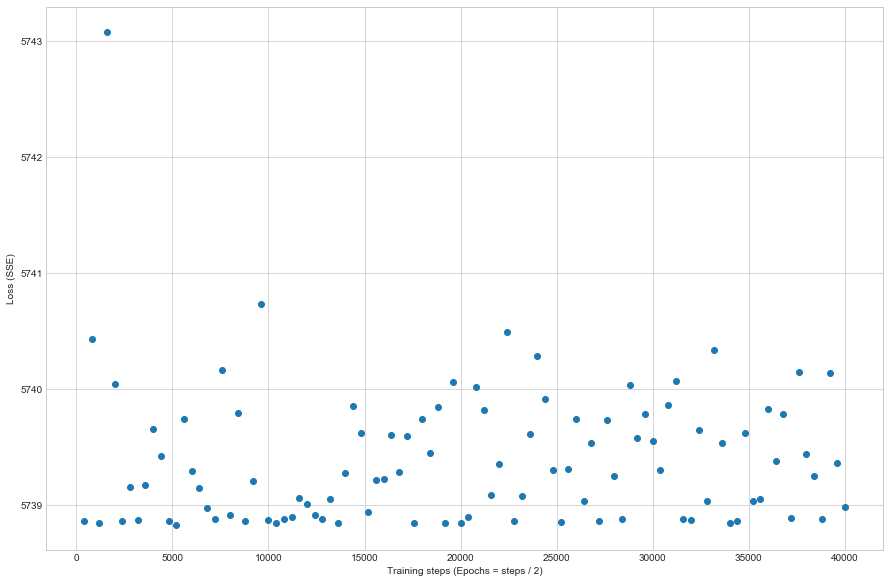

In [191]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps (Epochs = steps / 2)')  
plt.ylabel('Loss (SSE)')  
plt.show()  